In [1]:
import os, shutil
from pathlib import Path
from os.path import join as joinpath
from os import listdir

import sys, copy
import itertools, math

from functools import partial
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm import tqdm_notebook as tqdm
# from tqdm.autonotebook import tqdm
# from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics

import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.autograd as autograd

import captum.attr
import scipy

In [2]:
pd.options.mode.chained_assignment = None 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

pltparams = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'figure.titlesize': 'x-large',
    'savefig.dpi': 600,
}
plt.rcParams.update(pltparams)

sns.set(font_scale = 1.2)

In [3]:
basedir = "/mnt/beegfs/home/vu/Codalab-MetaDL"
datadir = joinpath(basedir, "data/")

random_seed = 2021

labelcolumn = "label"
filecolumn = "filename"

In [11]:
# dataname = 'resisc45-label_embed'
# datadomain = "remotesensing"

# collectiondir = joinpath(datadir, "resisc45")
# imagedir = joinpath(collectiondir, "images")

In [13]:

dataname = 'sd_v2_curated_20shots'
datadomain = "sd_v2"

collectiondir = joinpath(datadir, "sd-skindisease")
imagedir = joinpath(datadir, "sd-skindisease/sd-v2-curated")


In [21]:

figdir = joinpath(basedir, 'fig', datadomain, dataname)
modeldir = joinpath(basedir, 'model', datadomain, dataname)
metricdir = joinpath(basedir, 'metric', datadomain, dataname)

# for outputdir in (figdir, modeldir, resultdir):
#     os.makedirs(outputdir, exist_ok=True)

## Regularize

In [25]:
def filter_resultfile(resultfile):
    includes = "nodropout dropout0101 dropout0202 weightdecay10".split()
    excludes = "weightdecay5 weightdecay30 weightdecay40 nodropout_sgd-imagesize dropout0201 dropblock".split()
    if not resultfile.endswith(".json") or any(exclude in resultfile for exclude in excludes):
        return False
    return any(include in resultfile for include in includes)
    
def filter_resultdir(resultdir):
    includes = "nodropout dropout0101 dropout0202 weightdecay10".split()
    filtered = list(filter(filter_resultfile, listdir(resultdir)))
    return filtered

filter_resultdir(metricdir)

['sd_v2_curated_20shots-resnet18_sgd_nodropout_weightdecay10-imagesize_128x128.json',
 'sd_v2_curated_20shots-resnet18_sgd_nodropout_weightdecay20-imagesize_128x128.json',
 'sd_v2_curated_20shots-resnet18_sgd_dropout0202_weightdecay10-imagesize_128x128.json',
 'sd_v2_curated_20shots-resnet18_sgd_dropout0101_weightdecay20-imagesize_128x128.json',
 'sd_v2_curated_20shots-resnet18_sgd_dropout0101_weightdecay10-imagesize_128x128.json']

In [28]:
def extract_settings(resultfilename):
    start = resultfilename.find("sgd_") + 4
    return resultfilename[start:start + resultfilename[start:].find('-')]

list(map(extract_settings, filter_resultdir(metricdir)))

['nodropout_weightdecay10',
 'nodropout_weightdecay20',
 'dropout0202_weightdecay10',
 'dropout0101_weightdecay20',
 'dropout0101_weightdecay10']

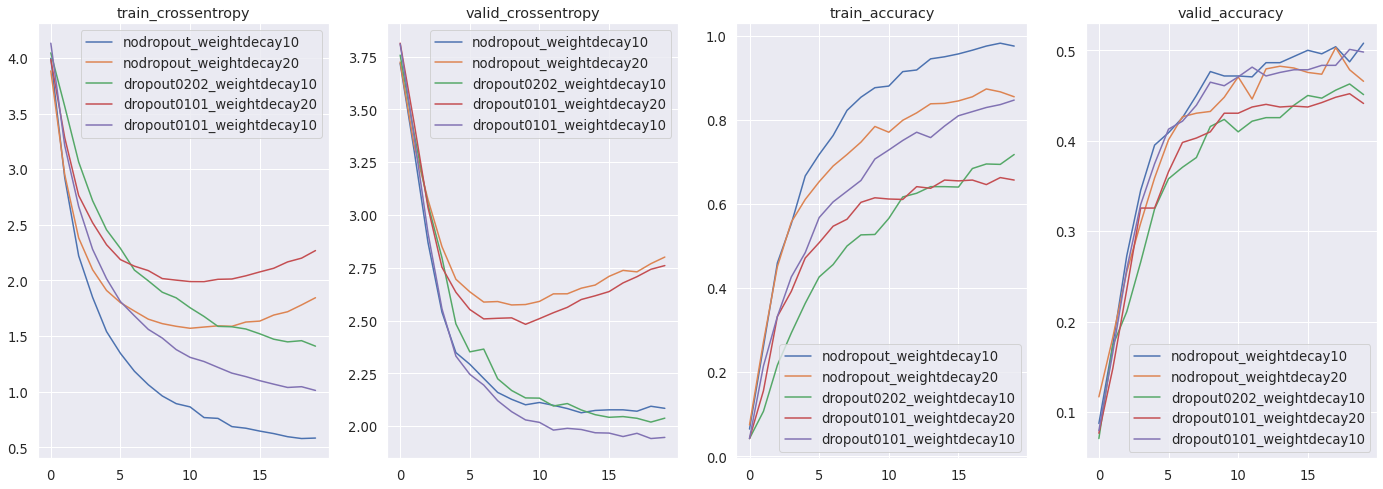

In [30]:
def plot_ax(ax, metric, dictkey, title, label):
    ax.plot(metric[dictkey], label=label)
    ax.set_title(title)
    ax.legend()
    
def plot_metrics(resultdir, figsize=(24, 8)):
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    axes = axes.flatten()

    filtered_files = filter_resultdir(resultdir)
    
    for file in filtered_files:
        label = extract_settings(file)
        with open(joinpath(resultdir, file)) as resultjson:
            metric = json.load(resultjson)
            plot_ax(axes[0], metric, "train_loss", "train_crossentropy", label)
            plot_ax(axes[1], metric, "valid_loss", "valid_crossentropy", label)
            plot_ax(axes[2], metric, "train_score", "train_accuracy", label)
            plot_ax(axes[3], metric, "valid_score", "valid_accuracy", label)
        
#         axes[0].plot(metric['valid_loss'], label=label)
#         axes[0].set_title("valid_crossentropyloss")
#         axes[0].legend()
        
#         axes[1].plot(metric['valid_score'], label=label)        
#         axes[1].set_title("valid_accuracy")
#         axes[1].legend()
    
    return fig
    
fig = plot_metrics(metricdir)

In [31]:
fig.savefig(joinpath(basedir, "fig", datadomain, "regularization.png"), bbox_inches='tight')

## Result

In [4]:
datanames = """\
multiderma
mini plantvillage
medleaf
mini resisc
mini rsicb
mini rsd
insects
plankton
texture1
texture2 dtd
omniprint metamix
omniprint meta6
omniprint meta5bis firstset\
""".replace(' ', '_').split('\n')

datanames


['multiderma',
 'mini_plantvillage',
 'medleaf',
 'mini_resisc',
 'mini_rsicb',
 'mini_rsd',
 'insects',
 'plankton',
 'texture1',
 'texture2_dtd',
 'omniprint_metamix',
 'omniprint_meta6',
 'omniprint_meta5bis_firstset']

In [5]:
allclasses20shots = \
"""
0.4486666667
0.8373333333
0.9240333333
0.7033333333
0.9077333333
0.4995666667
0.3436666667
0.5477666667
0.9426666667
0.5417666667
0.6328
0.6184666667
0.6807
"""
allclasses20shots = np.fromstring(allclasses20shots, dtype=float, sep='\n')
allclasses20shots

array([0.44866667, 0.83733333, 0.92403333, 0.70333333, 0.90773333,
       0.49956667, 0.34366667, 0.54776667, 0.94266667, 0.54176667,
       0.6328    , 0.61846667, 0.6807    ])

In [6]:
way5shot5 = \
"""
0.364
0.5259863946
0.5721904762
0.4639153439
0.5324867725
0.435978836
0.341038961
0.3918518519
0.6017460317
0.5392592593
0.3088551165
0.3205170068
0.2883485309
"""

way5shot5 = np.fromstring(way5shot5, dtype=float, sep='\n')
way5shot5

array([0.364     , 0.52598639, 0.57219048, 0.46391534, 0.53248677,
       0.43597884, 0.34103896, 0.39185185, 0.60174603, 0.53925926,
       0.30885512, 0.32051701, 0.28834853])

In [7]:
numberclasses= \
"""
51
37
27
45
45
46
114
91
64
47
706
703
706
"""
numberclasses = np.fromstring(numberclasses, dtype=int, sep='\n')
numberclasses

array([ 51,  37,  27,  45,  45,  46, 114,  91,  64,  47, 706, 703, 706])

In [21]:
resultdf = pd.DataFrame(
    {
        'dataname': datanames,
        'allclasses_20shots': allclasses20shots, 
        '5ways_5shots': way5shot5,
        'numberclasses': numberclasses,
    })
#     index = datanames)
resultdf

,dataname,allclasses_20shots,5ways_5shots,numberclasses
0,multiderma,0.448667,0.364000,51
1,mini_plantvillage,0.837333,0.525986,37
2,medleaf,0.924033,0.572190,27
3,mini_resisc,0.703333,0.463915,45
4,mini_rsicb,0.907733,0.532487,45
5,mini_rsd,0.499567,0.435979,46
6,insects,0.343667,0.341039,114
7,plankton,0.547767,0.391852,91
8,texture1,0.942667,0.601746,64
9,texture2_dtd,0.541767,0.539259,47


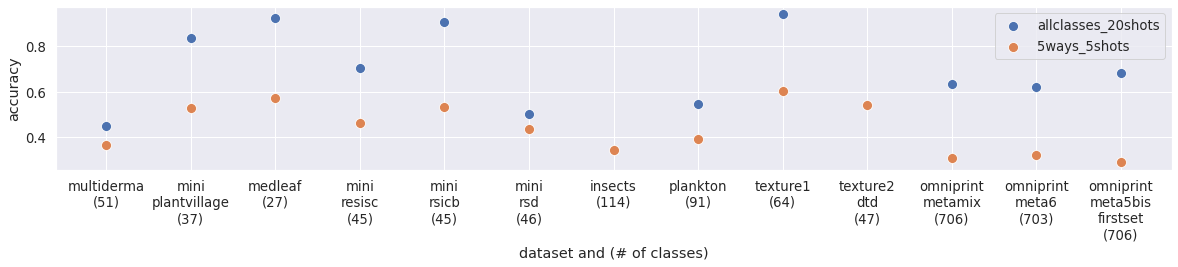

In [32]:
def plot_result(resultdf, figsize=(20, 3)):
    fig = plt.figure(figsize=figsize)
    for column in "allclasses_20shots 5ways_5shots".split(' '):
        ax = sns.scatterplot(data=resultdf, y=column, x=range(len(resultdf)), label=column, s=100)        
#         ax = sns.barplot(data=resultdf, y=column, x=resultdf.index, label=column)        
    
        ax.set_xticks(range(len(resultdf)))
        ax.set_xticklabels(resultdf.dataname.str.cat('(' + resultdf['numberclasses'].astype(str) + ')', sep='_')
           .str.replace('_', '\n'))
        
#     ax2 = ax.twinx()
#     sns.scatterplot(data=resultdf, y='numberclasses', x=range(len(resultdf)), label='# of classes')
    
    ax.set(ylabel="accuracy", xlabel="dataset and (# of classes)")

#     ax.figure.legend()
    return fig

fig = plot_result(resultdf)
fig.savefig(joinpath(basedir, "fig", "baseline-result.png"), bbox_inches='tight')

In [111]:
resultdf.index.str.cat('(' +resultdf['numberclasses'].astype(str) + ')', sep='_').str.replace('_', '\n')

Index(['multiderma\n(51)', 'mini\nplantvillage\n(37)', 'medleaf\n(27)',
       'mini\nresisc\n(45)', 'mini\nrsicb\n(45)', 'mini\nrsd\n(46)',
       'insects\n(114)', 'plankton\n(91)', 'texture1\n(64)',
       'texture2\ndtd\n(47)', 'omniprint\nmetamix\n(706)',
       'omniprint\nmeta6\n(703)', 'omniprint\nmeta5bis\nfirstset\n(706)'],
      dtype='object')

<AxesSubplot:xlabel='dataname', ylabel='value'>

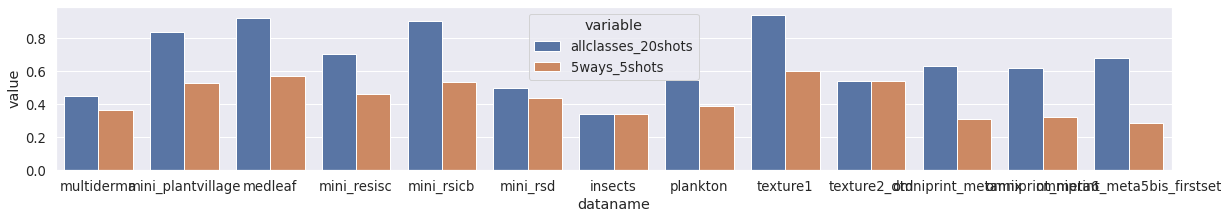

In [36]:
#https://stackoverflow.com/questions/52028043/side-by-side-barplot

plt.figure(figsize=(20, 3))
resultmelt = pd.melt(resultdf["dataname allclasses_20shots 5ways_5shots".split()], id_vars='dataname')
sns.barplot(data=resultmelt, x='dataname', y='value', hue='variable')